In [1]:
# tuning_ema_pullback_v3.ipynb

# ✅ CELDA 1: Preparación del entorno
import pandas as pd
import numpy as np
import itertools
from joblib import Parallel, delayed
from tqdm import tqdm

# Cargar resultados anteriores
df_senales = pd.read_csv("D:/trading/reports/backtest_heuristicas/v3_senales_raw.csv")

# Filtrar solo señales de ema_pullback_v3
df_ema = df_senales[df_senales["estrategia"] == "ema_pullback_v3"].copy()

# Cargar historicos (ya preparados en entorno local, sin modificar)
import os
ruta_historicos = "D:/trading/data/historic"
historicos = {}
for archivo in os.listdir(ruta_historicos):
    if archivo.endswith(".parquet"):
        ticker = archivo.replace(".parquet", "")
        df = pd.read_parquet(os.path.join(ruta_historicos, archivo))
        historicos[ticker] = df

print(f"Señales cargadas: {len(df_ema):,} | Símbolos disponibles: {len(historicos)}")


Señales cargadas: 19,963 | Símbolos disponibles: 48


In [2]:
# tuning_ema_pullback_v3.ipynb

# ✅ CELDA 2: Definir combinaciones de parámetros a testear
grid = list(itertools.product(
    [True, False],   # usar_filtro_volatilidad
    [True, False],   # rebote_required
    [True, False],   # tendencia_alcista
    [0.005, 0.0075, 0.01]  # atr_threshold
))

print(f"Total combinaciones a testear: {len(grid)}")


Total combinaciones a testear: 24


In [4]:
# tuning_ema_pullback_v3.ipynb
import sys
sys.path.append("D:/trading")  # o el path donde está tu carpeta my_modules


# ✅ CELDA 3: Función de simulación para una combinación de parámetros
from my_modules.estrategias.v3 import ema_pullback_v3

def simular_combinacion(params):
    usar_filtro_vol, rebote_req, tendencia_ok, atr_th = params
    resultados = []

    for ticker in df_ema["ticker"].unique():
        if ticker not in historicos:
            continue

        df_precio = historicos[ticker].copy()
        if not pd.api.types.is_datetime64_any_dtype(df_precio["fecha"]):
            df_precio["fecha"] = pd.to_datetime(df_precio["fecha"])

        # Generar señales con debug activado
        df_signals = ema_pullback_v3.generar_senales(df_precio, usar_filtro_vol, atr_th, debug=True)

        # Aplicar filtros condicionales manualmente
        if rebote_req:
            df_signals = df_signals[df_signals["rebote"] == True]
        if tendencia_ok:
            df_signals = df_signals[df_signals["tendencia_alcista"] == True]

        # Tomar solo señales BUY/SELL
        df_signals = df_signals[df_signals["signal"] != "hold"]
        if df_signals.empty:
            continue

        df_precio = df_precio.merge(df_signals[["fecha", "signal"]], on="fecha")

        for _, row in df_precio.iterrows():
            fecha_entrada = row["fecha"]
            precio_entrada = row["close"]
            df_rango = df_precio[(df_precio["fecha"] > fecha_entrada) & (df_precio["fecha"] <= fecha_entrada + pd.Timedelta(days=7))]
            if df_rango.empty:
                continue

            tipo_salida = "TIMEOUT"
            fila_salida = df_rango.iloc[-1]

            for _, f in df_rango.iterrows():
                if row["signal"] == "buy":
                    if f["high"] >= precio_entrada * 1.05:
                        tipo_salida = "TP"; fila_salida = f; break
                    if f["low"] <= precio_entrada * 0.97:
                        tipo_salida = "SL"; fila_salida = f; break
                elif row["signal"] == "sell":
                    if f["low"] <= precio_entrada * 0.95:
                        tipo_salida = "TP"; fila_salida = f; break
                    if f["high"] >= precio_entrada * 1.03:
                        tipo_salida = "SL"; fila_salida = f; break

            precio_salida = fila_salida["close"]
            dias = (fila_salida["fecha"] - fecha_entrada).days
            resultado = precio_salida - precio_entrada if row["signal"] == "buy" else precio_entrada - precio_salida
            ret_pct = (precio_salida / precio_entrada - 1) * (1 if row["signal"] == "buy" else -1)
            log_ret = np.log(precio_salida / precio_entrada) * (1 if row["signal"] == "buy" else -1)

            resultados.append({
                "resultado": resultado,
                "resultado_pct": ret_pct,
                "log_ret": log_ret,
                "f_win": int(resultado > 0),
                "dias": dias
            })

    df = pd.DataFrame(resultados)
    if df.empty:
        return {
            "usar_filtro_vol": usar_filtro_vol,
            "rebote_req": rebote_req,
            "tendencia_ok": tendencia_ok,
            "atr_threshold": atr_th,
            "n_trades": 0,
            "winrate": 0,
            "avg_profit": 0,
            "score": -999
        }

    return {
        "usar_filtro_vol": usar_filtro_vol,
        "rebote_req": rebote_req,
        "tendencia_ok": tendencia_ok,
        "atr_threshold": atr_th,
        "n_trades": len(df),
        "winrate": df["f_win"].mean(),
        "avg_profit": df["resultado"].mean(),
        "score": df["resultado"].mean() * df["f_win"].mean()
    }


In [5]:
# ✅ CELDA 4: Ejecutar tuning en paralelo
resultados = Parallel(n_jobs=-1)(
    delayed(simular_combinacion)(params) for params in tqdm(grid)
)

# Consolidar resultados
df_tuning = pd.DataFrame(resultados)
df_tuning = df_tuning.sort_values("score", ascending=False)

print("Top combinaciones por score:")
df_tuning.head(10)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:01<00:00,  2.58s/it]


Top combinaciones por score:


,usar_filtro_vol,rebote_req,tendencia_ok,atr_threshold,n_trades,winrate,avg_profit,score
2,True,True,True,0.0100,8480,0.850943,0.713165,0.606863
5,True,True,False,0.0100,8480,0.850943,0.713165,0.606863
4,True,True,False,0.0075,8925,0.844370,0.685274,0.578625
1,True,True,True,0.0075,8925,0.844370,0.685274,0.578625
3,True,True,False,0.0050,9299,0.840736,0.661275,0.555958
0,True,True,True,0.0050,9299,0.840736,0.661275,0.555958
14,False,True,True,0.0100,9452,0.838024,0.652527,0.546833
15,False,True,False,0.0050,9452,0.838024,0.652527,0.546833
17,False,True,False,0.0100,9452,0.838024,0.652527,0.546833
16,False,True,False,0.0075,9452,0.838024,0.652527,0.546833


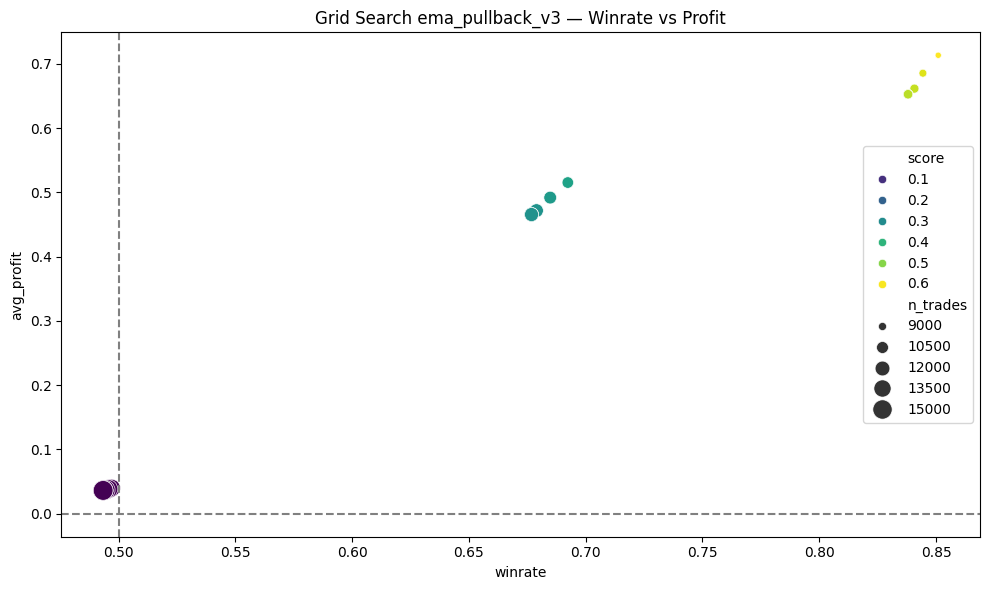

In [6]:
# tuning_ema_pullback_v3.ipynb

# ✅ CELDA 5: Exportar y graficar
import seaborn as sns
import matplotlib.pyplot as plt

# Guardar CSV
df_tuning.to_csv("D:/trading/reports/tuning_ema_pullback_v3.csv", index=False)

# Graficar
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_tuning, x="winrate", y="avg_profit", hue="score", size="n_trades", sizes=(20, 200), palette="viridis")
plt.title("Grid Search ema_pullback_v3 — Winrate vs Profit")
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0.5, color="gray", linestyle="--")
plt.tight_layout()
plt.show()
